In [1]:
import experiment_utils
from experiment_utils import config

config.experiment_name = "0000_poisson_dirichlet_1d"
config.target = "jmlr"
config.debug_mode = True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import probnum as pn

import linpde_gp
from linpde_gp.problems.pde import get_1d_dirichlet_boundary_observations

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
%matplotlib inline

plt.rcParams.update(config.tueplots_bundle(rel_width=0.5))

class BeliefPlotter:
    def __init__(self, bvp: linpde_gp.problems.pde.PoissonEquationDirichletProblem):
        self._bvp = bvp
        self._plt_grid = np.linspace(*bvp.pde.domain, 100)

    def plot_belief(
        self,
        ax,
        u: pn.randprocs.GaussianProcess,
        conditioned_on: list[str] = [],
        X_pde: np.ndarray | None = None,
        f_X_pde: pn.randvars.RandomVariable | None = None,
    ):
        u_conditional_strs = []

        for key in conditioned_on:
            if key == "bc":
                u_conditional_strs.append(r"u\vert_{\partial \Omega} = g")
            elif key == "pde":
                u_conditional_strs.append(r"-\Delta u(x_i) = f(x_i)")

        u_label = (
            fr"$u \mid {', '.join(u_conditional_strs)}$"
            if len(u_conditional_strs) > 0
            else "$u$"
        )

        u.plot(
            ax,
            self._plt_grid,
            num_samples=10,
            rng=np.random.default_rng(24),
            color="C0",
            label=u_label,
        )

        ax.plot(
            self._plt_grid,
            self._bvp.solution(self._plt_grid),
            color="C1",
            label="$u^*$",
        )

        for key in conditioned_on:
            if key == "bc":
                X_bc, Y_bc = get_1d_dirichlet_boundary_observations(self._bvp.boundary_conditions)

                ax.scatter(
                    X_bc,
                    Y_bc,
                    marker="+",
                    color="C2",
                    label=r"$g$",
                )
            elif key == "pde":
                linpde_gp.utils.plotting.plot_local_curvature(
                    ax,
                    xs=X_pde,
                    f_xs=u.mean(X_pde),
                    ddf_xs=-f_X_pde,
                    df_xs=(
                        linpde_gp.linfuncops.diffops.PartialDerivative(
                            linpde_gp.linfuncops.diffops.MultiIndex(1)
                        )(u)(X_pde).mean
                    ),
                    color="C3",
                    label=f"$(f(x_1), \dots, f(x_{X_pde.shape[0]}))$",
                )

        ax.legend()

    def plot_pred_belief(
        self,
        ax,
        u: pn.randprocs.GaussianProcess,
        conditioned_on: list[str] = [],
        X_pde: np.ndarray | None = None,
        f_X_pde: pn.randvars.RandomVariable | None = None,
    ):
        u_conditional_strs = []

        for key in conditioned_on:
            if key == "bc":
                u_conditional_strs.append(r"u\vert_{\partial \Omega} = g")
            elif key == "pde":
                u_conditional_strs.append(r"-\Delta u(x_i) = f(x_i)")

        u_label = (
            fr"$-\Delta u \mid {', '.join(u_conditional_strs)}$"
            if len(u_conditional_strs) > 0
            else "$-\Delta u$"
        )

        self._bvp.pde.diffop(u).plot(
            ax,
            self._plt_grid,
            num_samples=10,
            rng=np.random.default_rng(24),
            color="C0",
            label=u_label,
        )

        self._bvp.pde.rhs.plot(
            ax,
            self._plt_grid,
            color="C1",
            label="$f$",
        )

        if "pde" in conditioned_on:
            ax.scatter(
                X_pde,
                f_X_pde,
                marker="+",
                c="C3",
                label=f"$(f(x_1), \dots, f(x_{X_pde.shape[0]}))$",
            )

        ax.legend()

## Problem Definition

In [4]:
domain = linpde_gp.domains.asdomain([-1.0, 1.0])

In [5]:
# Boundary Values
g = np.asarray((0.0, 1.0))

# PDE RHS
f = linpde_gp.functions.Constant(input_shape=(), value=2.0)

# True Solution
solution = None

In [6]:
# Boundary Values
g = np.zeros(2)

# PDE RHS
f = pn.functions.LambdaFunction(lambda x: np.pi ** 2 * np.sin(np.pi * x), input_shape=())

# True Solution
solution = pn.functions.LambdaFunction(lambda x: np.sin(np.pi * x), input_shape=())

In [7]:
bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
    domain=domain,
    boundary_values=g,
    rhs=f,
    solution=solution,
)

plotter = BeliefPlotter(bvp)

## Prior

In [8]:
u_prior = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Zero(input_shape=()),
    cov=2.0 ** 2 * linpde_gp.randprocs.covfuncs.ExpQuad(
        input_shape=(),
        lengthscales=1.0,
    ),
)

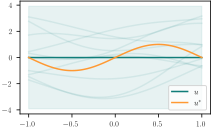

In [9]:
plotter.plot_belief(
    ax=plt.gca(),
    u=u_prior,
)

experiment_utils.savefig("00a_u_prior")

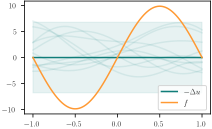

In [10]:
plotter.plot_pred_belief(
    ax=plt.gca(),
    u=u_prior,
)

experiment_utils.savefig("00b_Du_prior")

## Observations

In [11]:
X_pde = domain.uniform_grid((3,), inset=0.2)
Y_pde = bvp.pde.rhs(X_pde)

In [12]:
X_bc, Y_bc = get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

## Posterior (PDE First)

### Conditioning on the PDE

In [13]:
u_cond_pde = u_prior.condition_on_observations(
    Y_pde,
    X=X_pde,
    L=bvp.pde.diffop,
)

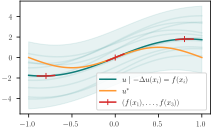

In [14]:
plotter.plot_belief(
    ax=plt.gca(),
    u=u_cond_pde,
    conditioned_on=["pde"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("pdefirst_01a_u_cond_pde")

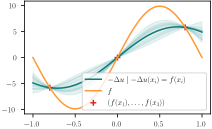

In [15]:
plotter.plot_pred_belief(
    ax=plt.gca(),
    u=u_cond_pde,
    conditioned_on=["pde"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("pdefirst_01b_Du_cond_pde")

### Conditioning on the Boundary Conditions

In [16]:
u_cond_pde_bc = u_cond_pde.condition_on_observations(Y_bc, X=X_bc)

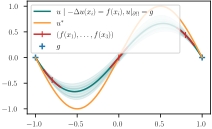

In [17]:
plotter.plot_belief(
    ax=plt.gca(),
    u=u_cond_pde_bc,
    conditioned_on=["pde", "bc"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("pdefirst_02a_u_cond_pde_bc")

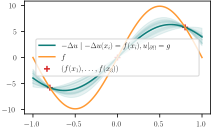

In [18]:
plotter.plot_pred_belief(
    ax=plt.gca(),
    u=u_cond_pde_bc,
    conditioned_on=["pde", "bc"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("pdefirst_02b_Du_cond_pde_bc")

### Complete Plot

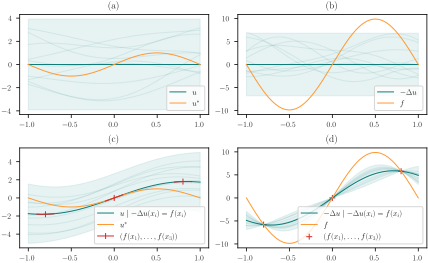

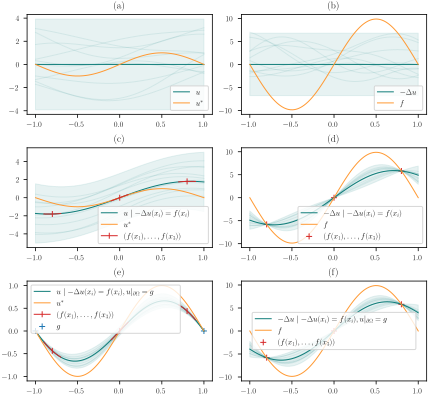

In [19]:
for include_bc in [False, True]:
    nrows = 3 if include_bc else 2

    rc = config.tueplots_bundle(nrows=nrows, ncols=2)
    rc.update(
        {
            "lines.linewidth": 1
        }
    )

    with plt.rc_context(rc):
        fig, ax = plt.subplots(nrows=nrows, ncols=2)

        ax[0, 0].set_title("(a)")

        plotter.plot_belief(
            ax=ax[0, 0],
            u=u_prior,
        )

        ax[0, 1].set_title("(b)")

        plotter.plot_pred_belief(
            ax=ax[0, 1],
            u=u_prior,
        )

        ax[1, 0].set_title("(c)")

        plotter.plot_belief(
            ax=ax[1, 0],
            u=u_cond_pde,
            conditioned_on=["pde"],
            X_pde=X_pde,
            f_X_pde=Y_pde,
        )

        ax[1, 1].set_title("(d)")

        plotter.plot_pred_belief(
            ax=ax[1, 1],
            u=u_cond_pde,
            conditioned_on=["pde"],
            X_pde=X_pde,
            f_X_pde=Y_pde,
        )

        if include_bc:
            ax[2, 0].set_title("(e)")

            plotter.plot_belief(
                ax=ax[2, 0],
                u=u_cond_pde_bc,
                conditioned_on=["pde", "bc"],
                X_pde=X_pde,
                f_X_pde=Y_pde,
            )

            ax[2, 1].set_title("(f)")

            plotter.plot_pred_belief(
                ax=ax[2, 1],
                u=u_cond_pde_bc,
                conditioned_on=["pde", "bc"],
                X_pde=X_pde,
                f_X_pde=Y_pde,
            )

    experiment_utils.savefig("pdefirst" + ("" if include_bc else "_nobc"))

## Posterior (Boundary Values First)

### Conditioning on Boundary Conditions

In [20]:
u_cond_bc = u_prior.condition_on_observations(Y_bc, X=X_bc)

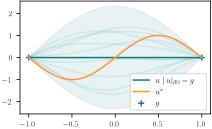

In [21]:
plotter.plot_belief(
    ax=plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
)

experiment_utils.savefig("bcfirst_01a_u_cond_bc")

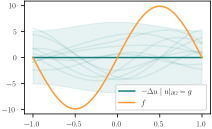

In [22]:
plotter.plot_pred_belief(
    ax=plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
)

experiment_utils.savefig("bcfirst_01b_Du_cond_bc")

### Conditioning on the PDE

In [23]:
u_cond_bc_pde = u_cond_bc.condition_on_observations(
    Y=Y_pde,
    L=bvp.pde.diffop,
    X=X_pde,
)

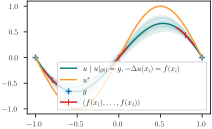

In [24]:
plotter.plot_belief(
    ax=plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "pde"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("bcfirst_02a_u_cond_bc_pde")

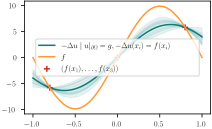

In [25]:
plotter.plot_pred_belief(
    ax=plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "pde"],
    X_pde=X_pde,
    f_X_pde=Y_pde,
)

experiment_utils.savefig("bcfirst_02b_Du_cond_bc_pde")

### Complete Plot

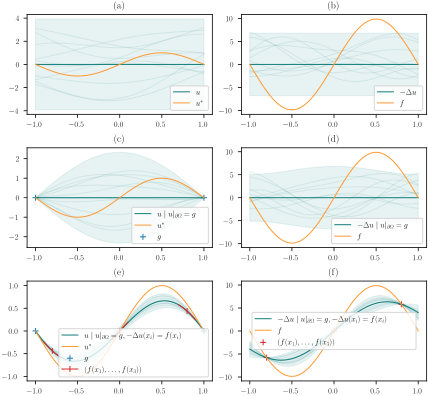

In [26]:
rc = config.tueplots_bundle(nrows=3, ncols=2)
rc.update(
    {
        "lines.linewidth": 1
    }
)

with plt.rc_context(rc):
    fig, ax = plt.subplots(nrows=3, ncols=2)

    ax[0, 0].set_title("(a)")

    plotter.plot_belief(
        ax=ax[0, 0],
        u=u_prior,
    )

    ax[0, 1].set_title("(b)")

    plotter.plot_pred_belief(
        ax=ax[0, 1],
        u=u_prior,
    )

    ax[1, 0].set_title("(c)")

    plotter.plot_belief(
        ax=ax[1, 0],
        u=u_cond_bc,
        conditioned_on=["bc"],
    )

    ax[1, 1].set_title("(d)")

    plotter.plot_pred_belief(
        ax=ax[1, 1],
        u=u_cond_bc,
        conditioned_on=["bc"],
    )

    ax[2, 0].set_title("(e)")

    plotter.plot_belief(
        ax=ax[2, 0],
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        X_pde=X_pde,
        f_X_pde=Y_pde,
    )

    ax[2, 1].set_title("(f)")

    plotter.plot_pred_belief(
        ax=ax[2, 1],
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        X_pde=X_pde,
        f_X_pde=Y_pde,
    )

experiment_utils.savefig("bcfirst")

## Interactive Example

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), description='Domain [l, r]', max=3.0, min=-3.0), Flo…

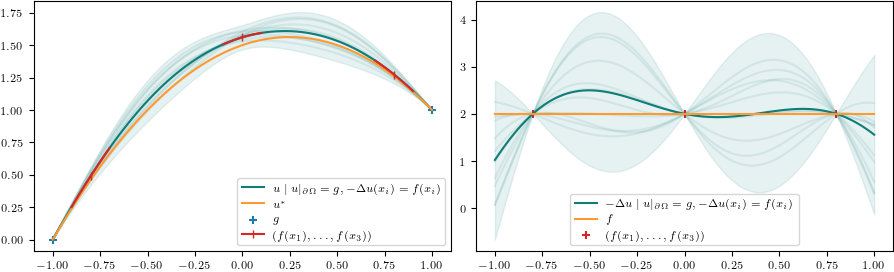

In [27]:
import ipywidgets

%matplotlib widget

with plt.rc_context(config.tueplots_bundle(ncols=2, rel_width=1.5)):
    fig, ax = plt.subplots(
        num="Gaussian Process Solution to the Dirichlet Problem for the 1D Poisson Equation",
        ncols=2,
    )

@ipywidgets.interact(
    domain=ipywidgets.FloatRangeSlider(
        value=(-1.0, 1.0),
        min=-3.0,
        max=3.0,
        description="Domain [l, r]",
    ),
    f=ipywidgets.FloatSlider(
        value=2.0,
        min=-3.0,
        max=3.0,
        description="f(x)",
    ),
    f_std=ipywidgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=1.0,
        description="f(x) std",
    ),
    u_l=ipywidgets.FloatSlider(
        value=0.0,
        min=-2.0,
        max=2.0,
        description="g(l)",
    ),
    u_l_std=ipywidgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=1.0,
        description="g(l) std",
    ),
    u_r=ipywidgets.FloatSlider(
        value=1.0,
        min=-2.0,
        max=2.0,
        description="g(r)",
    ),
    u_r_std=ipywidgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=1.0,
        description="g(r) std",
    ),
    prior_output_scale=ipywidgets.FloatSlider(
        value=2.0,
        min=0.1,
        max=8.0,
        description="σ",
    ),
    prior_lengthscale=ipywidgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=2.0,
        description="λ",
    ),
    collocation_range=ipywidgets.FloatRangeSlider(
        value=(0.1, 0.9),
        min=1e-6,
        max=1.0 - 1e-6,
        description="X_pde range",
    ),
    num_collocation_points=ipywidgets.IntSlider(
        value=3,
        min=1,
        max=10,
        description="len(X_pde)",
    ),
)
def interact(
    domain: tuple,
    f: float,
    f_std: float,
    u_l: float,
    u_l_std: float,
    u_r: float,
    u_r_std: float,
    prior_output_scale: float,
    prior_lengthscale: float,
    collocation_range: tuple,
    num_collocation_points: int,
):
    collocation_range = tuple(
        (domain[1] - domain[0]) * bound + domain[0] for bound in collocation_range
    )

    # Problem definition
    bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
        domain=domain,
        rhs=linpde_gp.functions.Constant(input_shape=(), value=f),
        boundary_values=(u_l, u_r),
    )

    u_prior = pn.randprocs.GaussianProcess(
        mean=linpde_gp.functions.Zero(
            input_shape=bvp.pde.diffop.input_domain_shape,
            output_shape=bvp.pde.diffop.input_codomain_shape,
        ),
        cov=prior_output_scale ** 2 * linpde_gp.randprocs.covfuncs.ExpQuad(
            input_shape=bvp.pde.diffop.input_domain_shape,
            lengthscales=prior_lengthscale,
        ),
    )

    # Solve the BVP
    X_bc, Y_bc = get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

    u_cond_bc = u_prior.condition_on_observations(
        Y=Y_bc,
        X=X_bc,
        b=pn.randvars.Normal(np.zeros_like(Y_bc), np.diag((u_l_std**2, u_r_std**2))),
    )

    X_pde = np.linspace(*collocation_range, num_collocation_points)
    Y_pde = bvp.pde.rhs(X_pde)

    u_cond_bc_pde = u_cond_bc.condition_on_observations(
        Y_pde,
        L=bvp.pde.diffop,
        X=X_pde,
        b=pn.randvars.Normal(np.zeros_like(Y_pde), f_std**2 * np.eye(Y_pde.size)),
    )

    # Plotting
    plotter = BeliefPlotter(bvp)

    ax[0].cla()
    ax[1].cla()

    plotter.plot_belief(
        ax[0],
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        X_pde=X_pde,
        f_X_pde=Y_pde,
    )
    plotter.plot_pred_belief(
        ax[1],
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        X_pde=X_pde,
        f_X_pde=Y_pde,
    )

    fig.canvas.draw()
